In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

In [ ]:
from src.d00_utils.utils import add_percent_columns
from src.d02_intermediate.classifier_data_api import ClassifierDataApi
from src.d01_data.block_data_api import BlockDataApi
from src.d04_modeling import propositional_classifier as pc
from src.d04_modeling.naive_classifier import NaiveClassifier

We load the data with an arbitrary classifier, and get an instance of the ClassifierDataApi class to access the data:

In [3]:
load_data = pc.andClassifier(["nFRL"])
cda = ClassifierDataApi()

Loading Block FRL data...0.2007
Loading Block Demographic data...0.5321
Loading Student Demographic data...2.6087


# Focal Neighborhood Proxies

So far we have developed classifiers to label each block as either focal or non-focal. Ignoring block groups due to anonimization issues, we always considered only the single-block features for this classification task. In this notebook I introduce the idea of adding a condition that in order to be focal a block must be in a "focal neighborhood." Benefits of doing this are:

1. Some blocks might contain focal students as noted in the dataset, but those students may be receiving much better infrastructure (transportation, access to good pre-K schools) than other focal students.
2. The tiebreaker will be more robust and interpretable if the focal blocks are not as scattered. The neighborhood criterion could aid reducing scattering.

Namely, we started this approach due to concerns with the focal status of FRL-receiving students in the Northwest of San Francisco. We would like to attribute some weight to the fact that those students live in a higher-developed neighborhood than students living in the Southeast of the city. We can see in the map below that many blocks in the Northwest have a high rate of FRL-receiving students.

Loading Block FRL data...0.0939
Loading Block Demographic data...0.1524
Loading Student Demographic data...1.1557


Text(0.5, 1.0, 'Focal (%)')

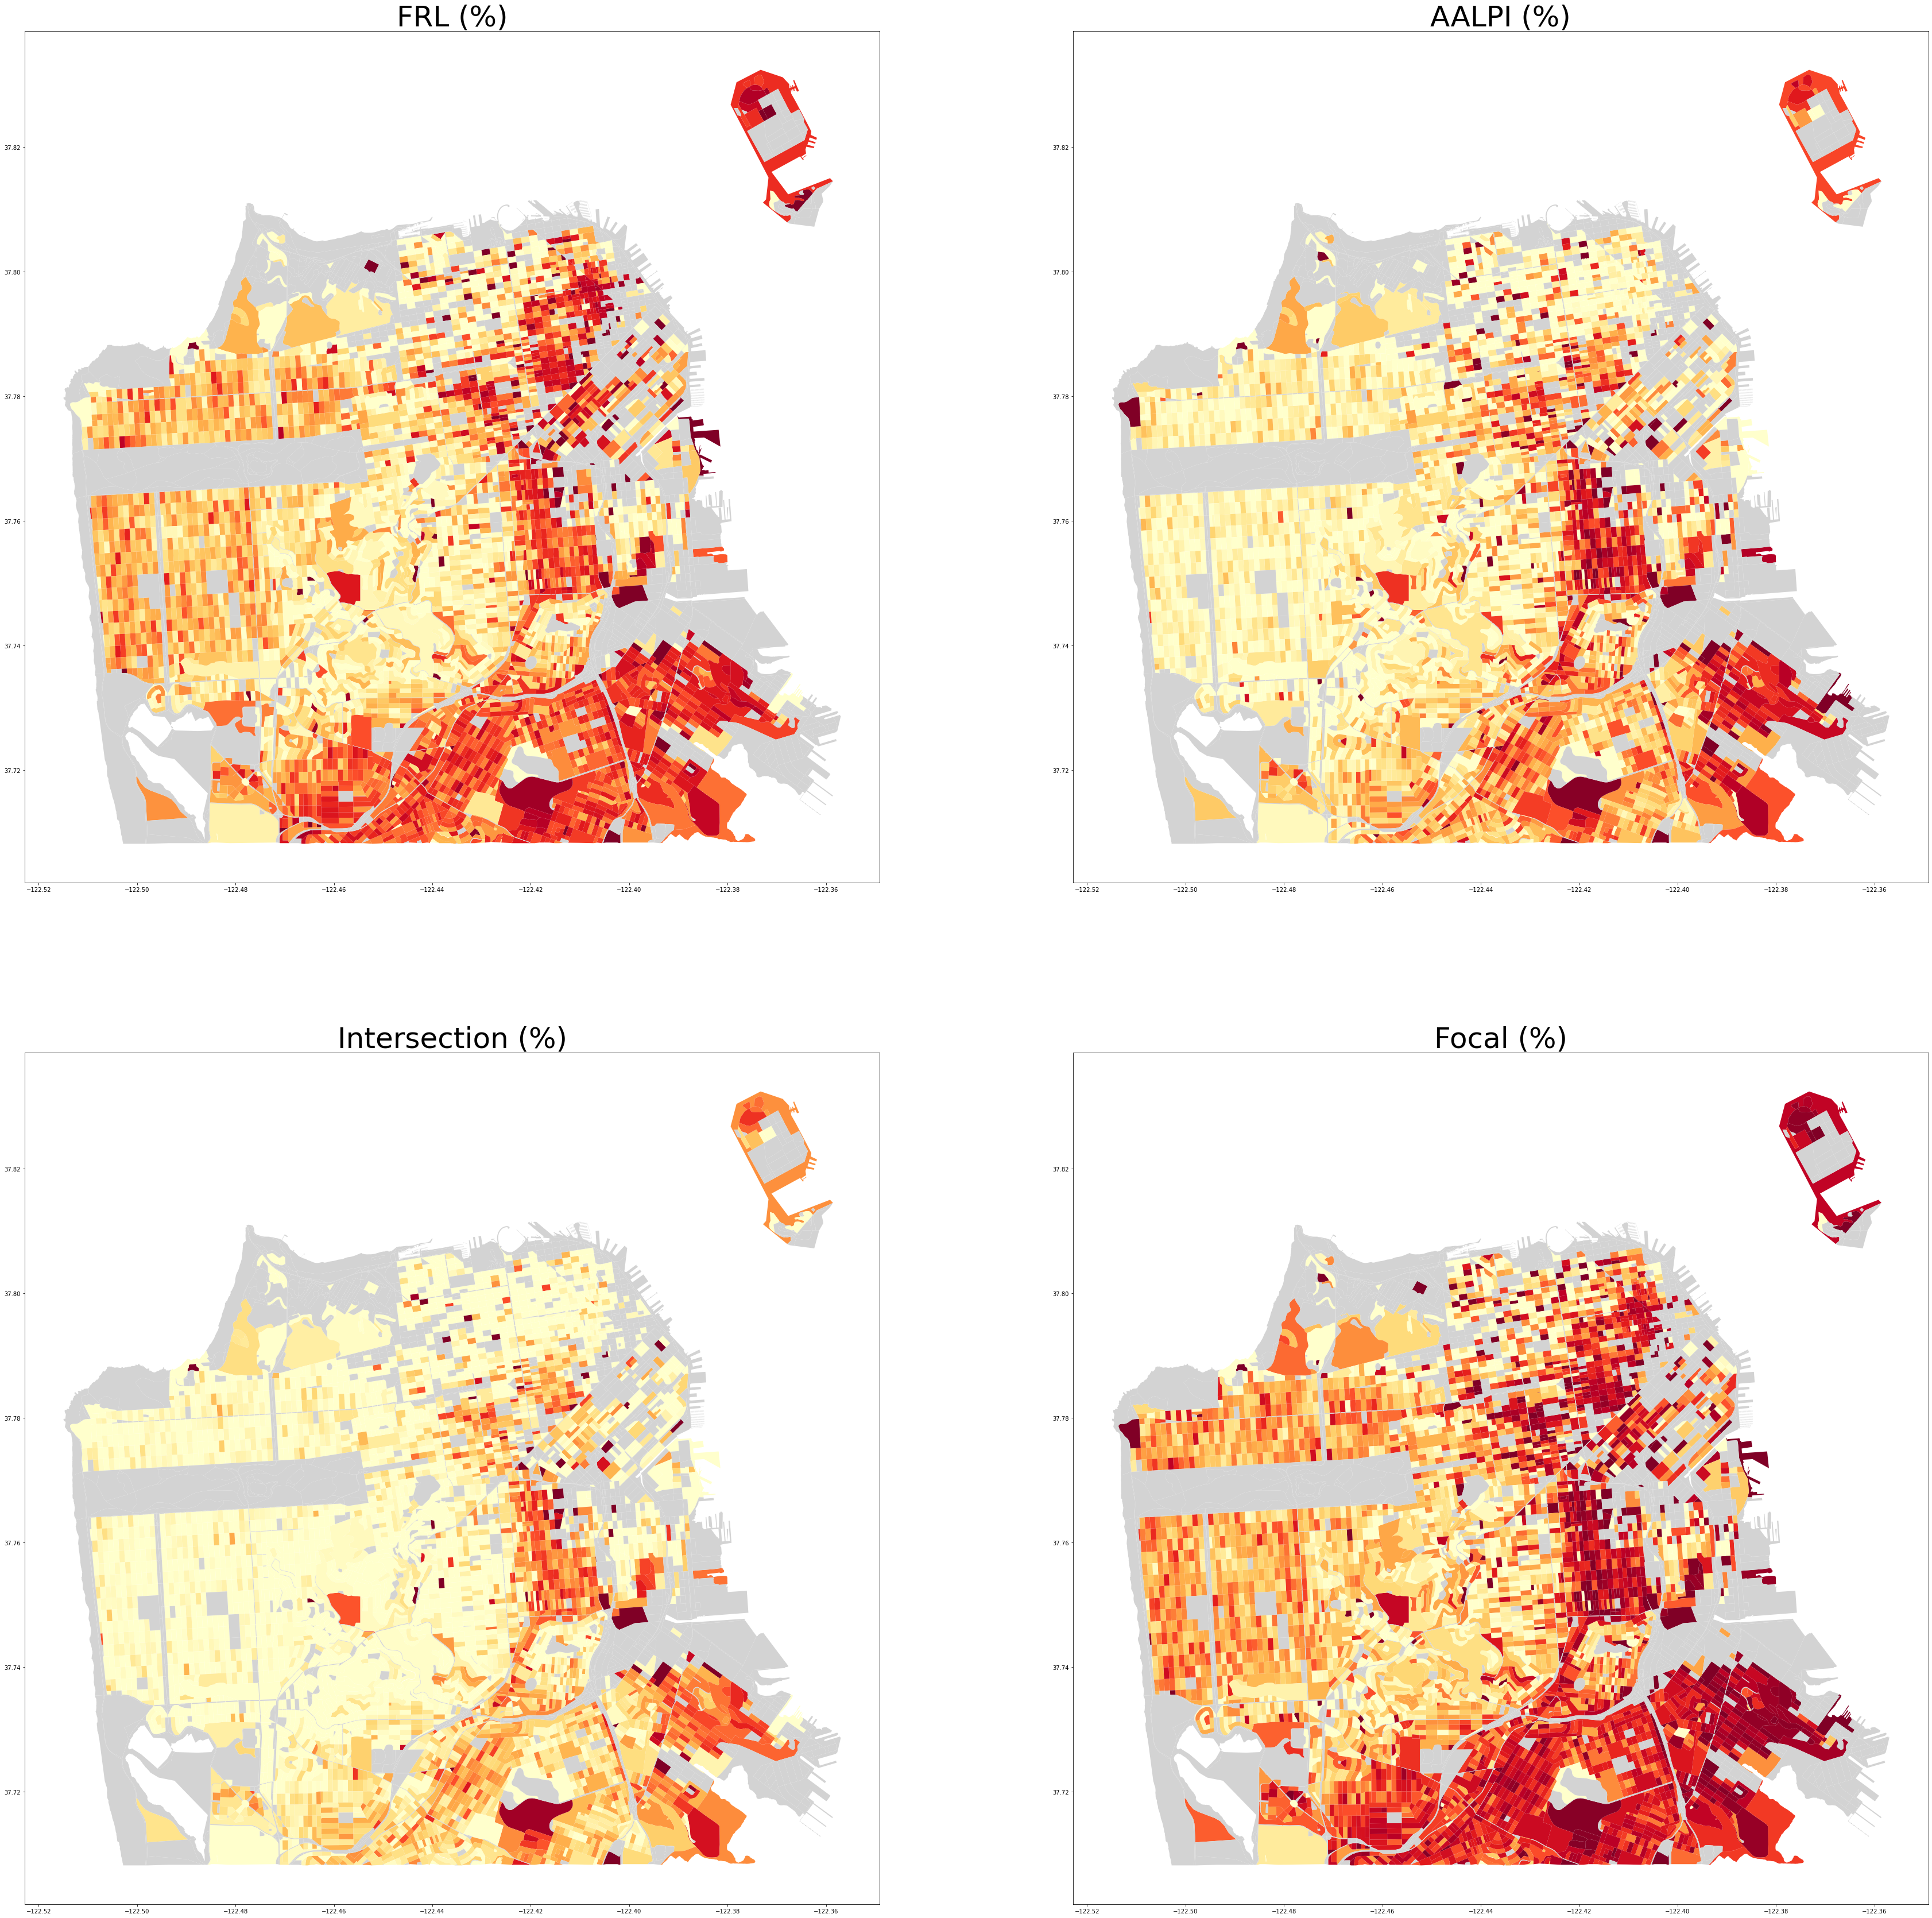

In [4]:
map_df_raw = cda.get_map_df_data(cols=["n", "nFocal", "nFRL", "nAALPI", "nBoth"])
map_df_data = add_percent_columns(map_df_raw)

fig, Axes = plt.subplots(figsize=(60,60), ncols=2, nrows=2)
axFRL = map_df_data.plot(column="pctFRL", ax=Axes[0,0], cmap="YlOrRd",
                         legend=False, legend_kwds={'orientation': "horizontal"},
                         missing_kwds={'color': 'lightgrey'})
Axes[0,0].set_title("FRL (%)", fontsize=50)
axFRL = map_df_data.plot(column="pctAALPI", ax=Axes[0,1], cmap="YlOrRd",
                         legend=False, legend_kwds={'orientation': "horizontal"},
                         missing_kwds={'color': 'lightgrey'})
Axes[0,1].set_title("AALPI (%)", fontsize=50)
axBoth = map_df_data.plot(column="pctBoth", ax=Axes[1,0], cmap="YlOrRd",
                         legend=False, legend_kwds={'orientation': "horizontal"},
                         missing_kwds={'color': 'lightgrey'})
Axes[1,0].set_title("Intersection (%)", fontsize=50)
axFocal = map_df_data.plot(column="pctFocal", ax=Axes[1,1], cmap="YlOrRd",
                         legend=False, legend_kwds={'orientation': "horizontal"},
                         missing_kwds={'color': 'lightgrey'})
Axes[1,1].set_title("Focal (%)", fontsize=50)

The main idea is to incorporate the neighborhood condition (N_COND) into the propositional classifier. This way N_COND will either evaluate to True or False for each block. Blocks in the same neighborhood will have the same value of N_COND. Probably it will be better to incorporate (to adhere to goals 1 and 2) this condition in conjunction to an existing tiebreaker (PROP). That is, a block receives a tiebreaker if the following expression is true:

$$ \text{PROP} \quad\text{and}\quad \text{N_COND}$$

Meaning that the block must satisfy simultaneously the (1) block-level criteria and (2) the neighborhood condition. An example of this classifier would be, assuming we could measure a neighborhood median income directly, to give a tiebreaker to blocks satisfying:

$$ (\text{pctAALPI }\geq 0.5\quad\text{or}\quad \text{pctFRL } \geq 0.6)\quad\text{and}\quad \text{NbhdMedianInc} \leq 50,000 $$

The definition of neighborhood we will probably use is the BlockGroup. BlockGroups can be visualized in the following map. Note that trimming the Block Group id (10 digits by default) leads to a coarser neighborhood partition:

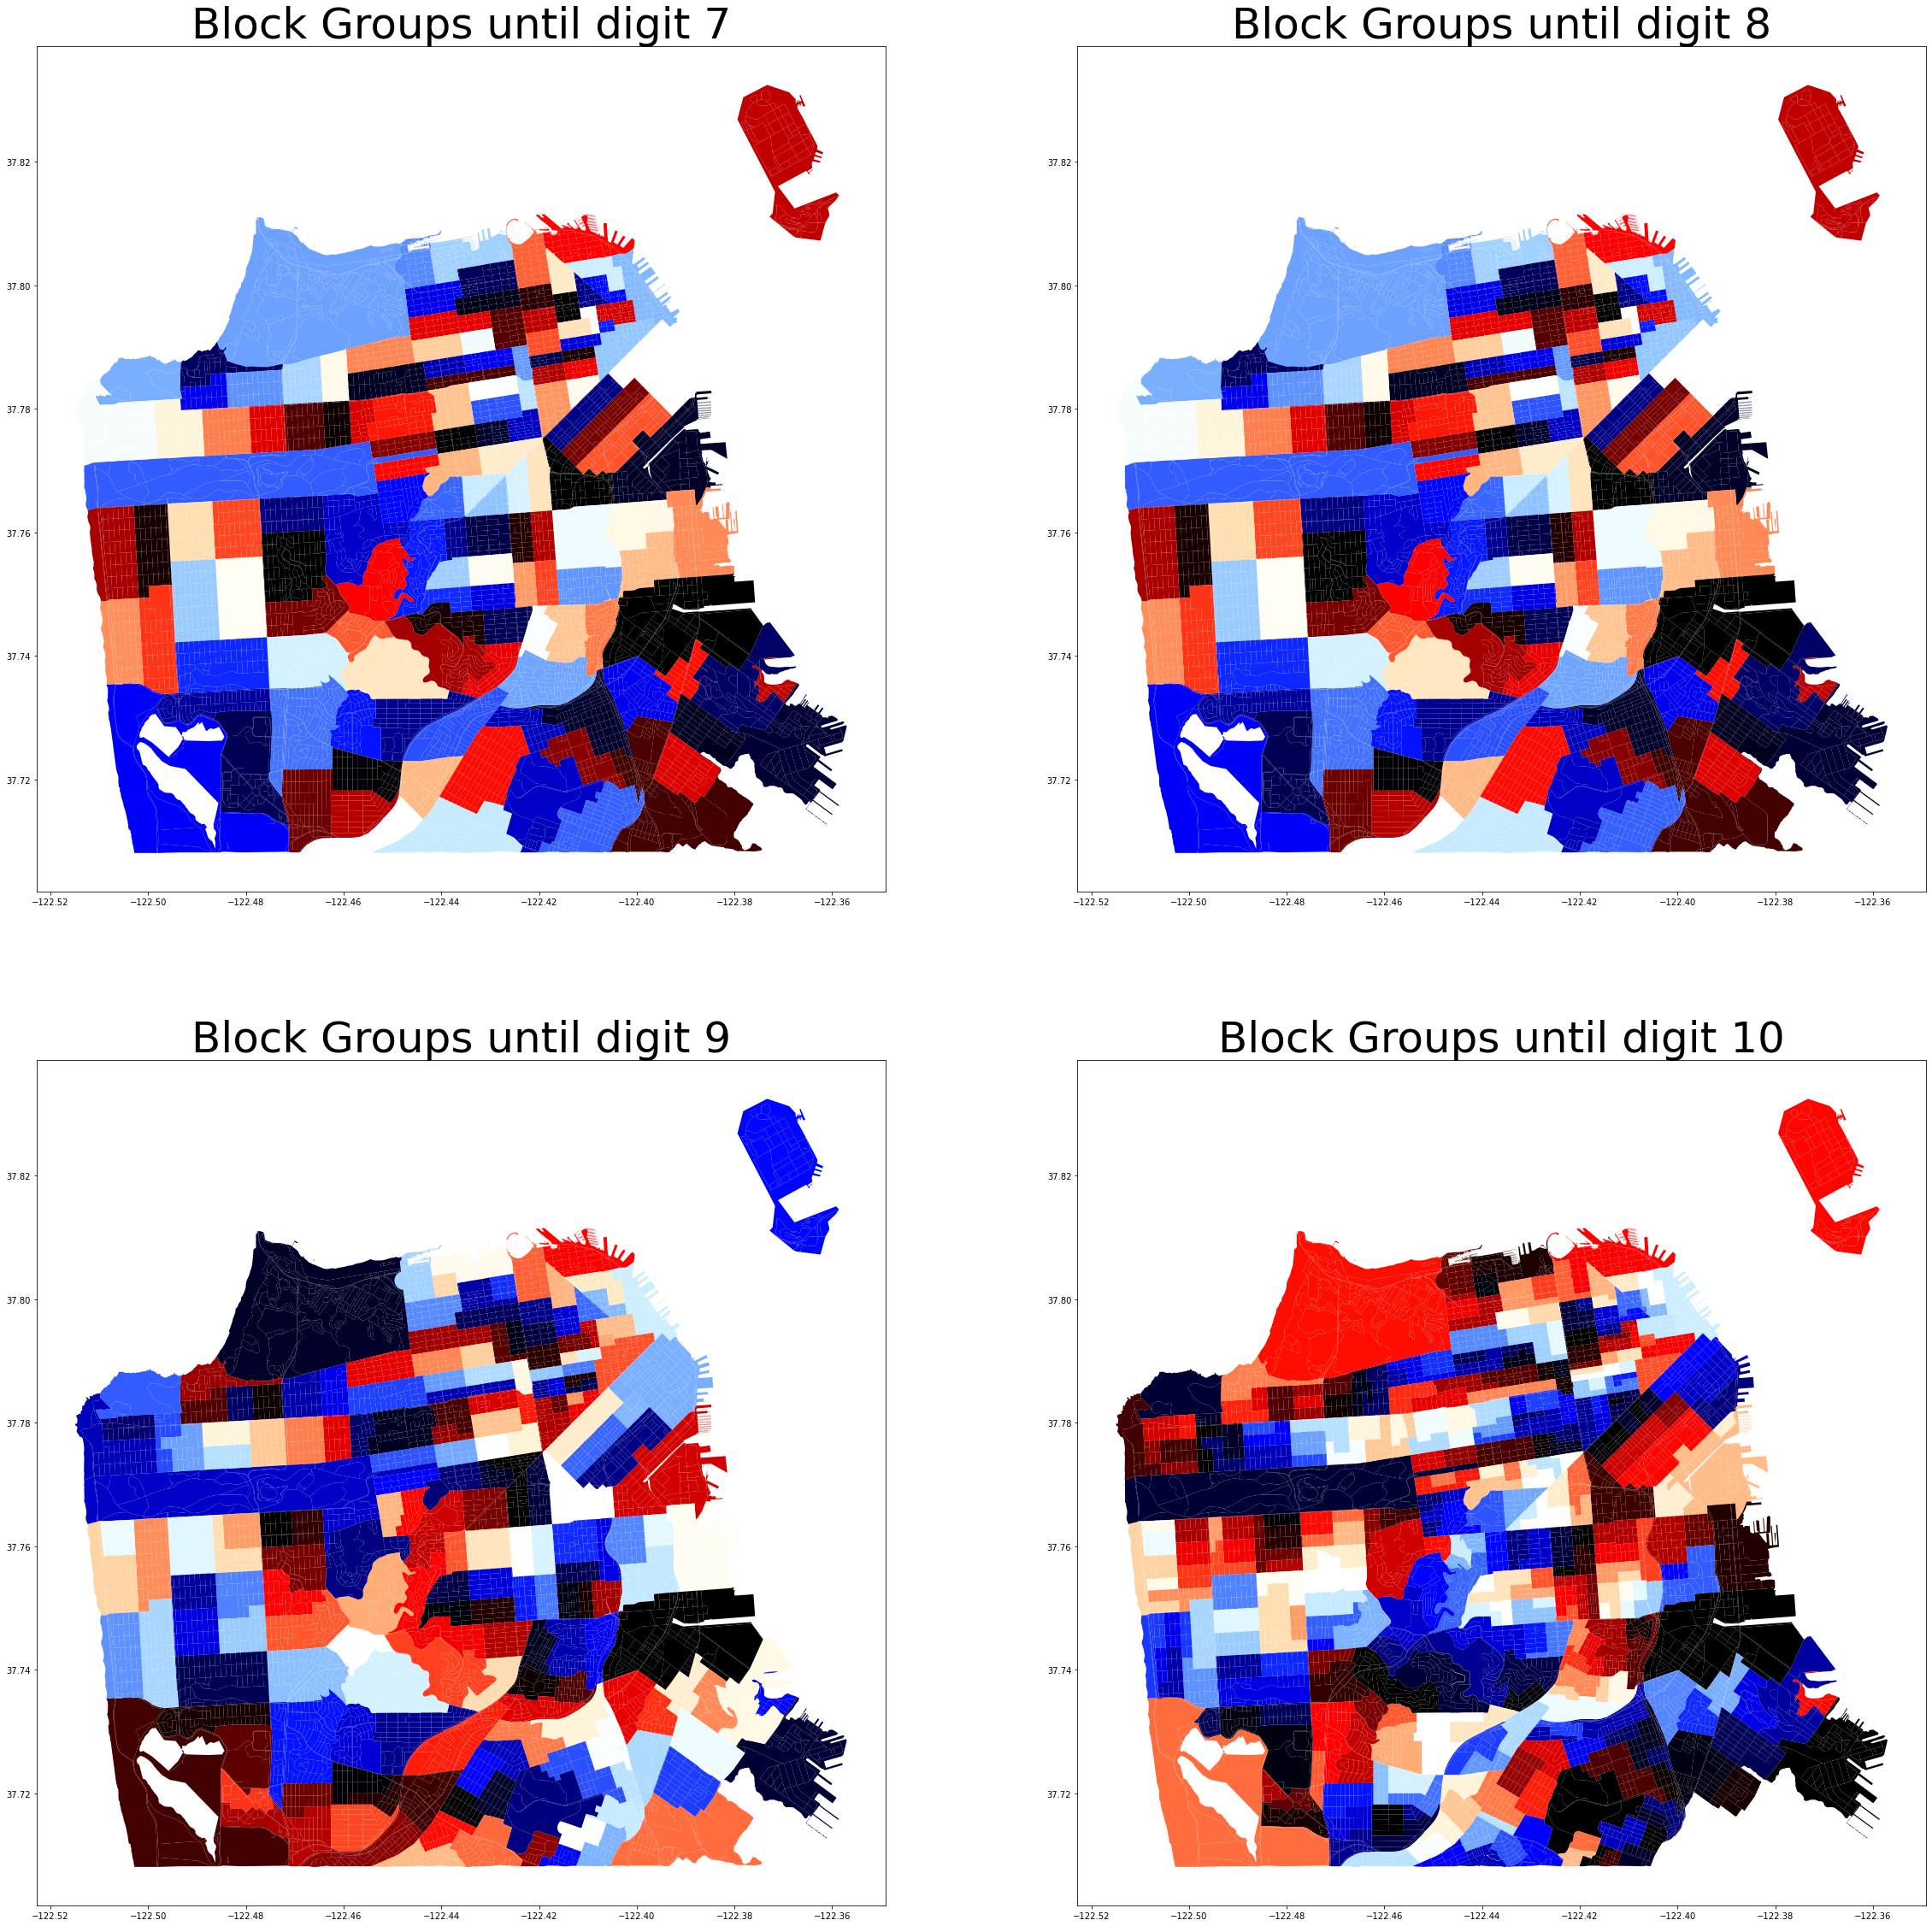

In [5]:
map_df_bg = cda.get_map_df_data(cols=["BlockGroup"])
fig, Axes = plt.subplots(figsize=(40,40), nrows=2, ncols=2)

k=8
for ax in Axes.flatten():
    new_map_df = map_df_bg.copy()
    new_map_df["BlockGroup"] = new_map_df["BlockGroup"].astype(str).str.slice(stop=k)
    new_map_df["RankGroup"] = new_map_df["BlockGroup"].rank(method="dense")
    ax = new_map_df.plot(column="RankGroup", ax=ax, cmap="flag",
                        legend=False, missing_kwds={'color': 'lightgrey'})
    ax.set_title("Block Groups until digit " + str(k-1), fontsize=50)
    k += 1

Another option of neighborhood unit is the analysis neighborhood.

Text(0.5, 1.0, 'San Francisco Analysis Neighborhoods')

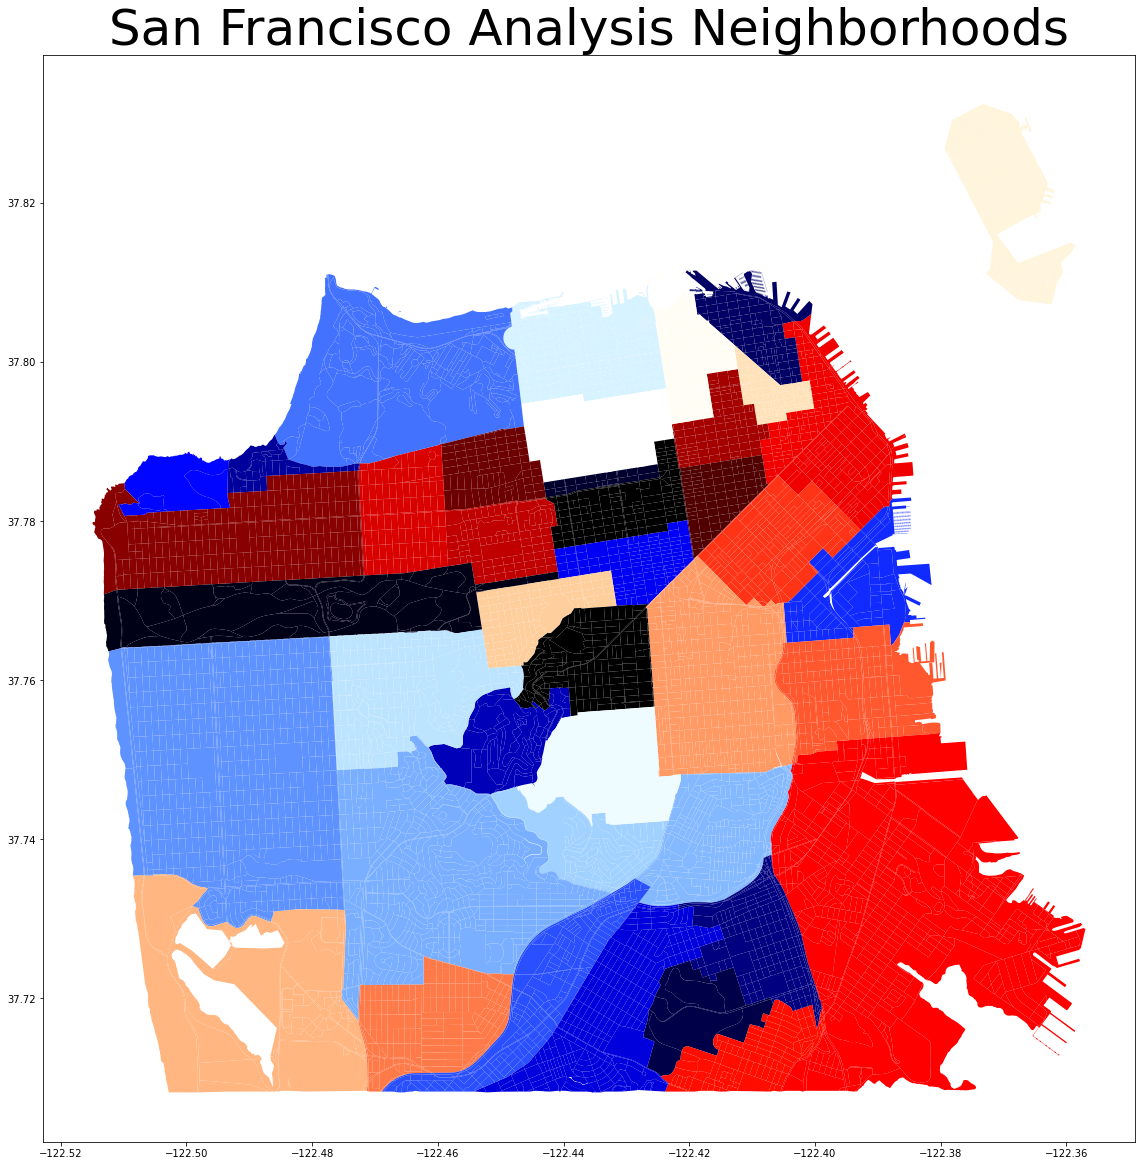

In [6]:
map_df_nb = cda.get_map_df_data(cols=["Neighborhood"])
fig, ax = plt.subplots(figsize=(20,20))
ax = map_df_nb.plot(column="Neighborhood", ax=ax, cmap="flag",
                    legend=False, missing_kwds={'color': 'lightgrey'},
                    categorical=True)
ax.set_title("San Francisco Analysis Neighborhoods", fontsize=50)

We can initialize a classifier with a group_criterion to be either None (default), "block_group", or "nbhd" and be in one of those scenarios. If we select "block_group", we can specify the coarseness of the block group id (default is 8 digits):

In [7]:
c1 = pc.andClassifier(["pctFocal"], group_criterion="block_group", len_BG=8)
c2 = pc.andClassifier(["pctFocal"], group_criterion="nbhd")
c3 = pc.andClassifier(["pctFocal"], group_criterion=None)  #default!

## 1. FRL and AALPI based Proxies:

The first time around, I will build proxies only taking into account the focal student data provided by the district. This will enforce that a tiebreaker-receiving block is not completely detached from its neighborhood judging by the same criteria.

In [8]:
c1 = pc.andClassifier(["pctFocal"])
c2 = pc.andClassifier(["BG_pctFocal"], group_criterion="block_group")
c3 = pc.andClassifier(["BG_pctFocal"], group_criterion="nbhd")

For example, if we were to give the tiebreaker only to blockgroups where the percentage of focal students is above a certain threshold, we would obtain the following ROC curve (and compare it to the curve obtained from only considering the individual percentage):

Block
Block Group (8)
Neighborhood


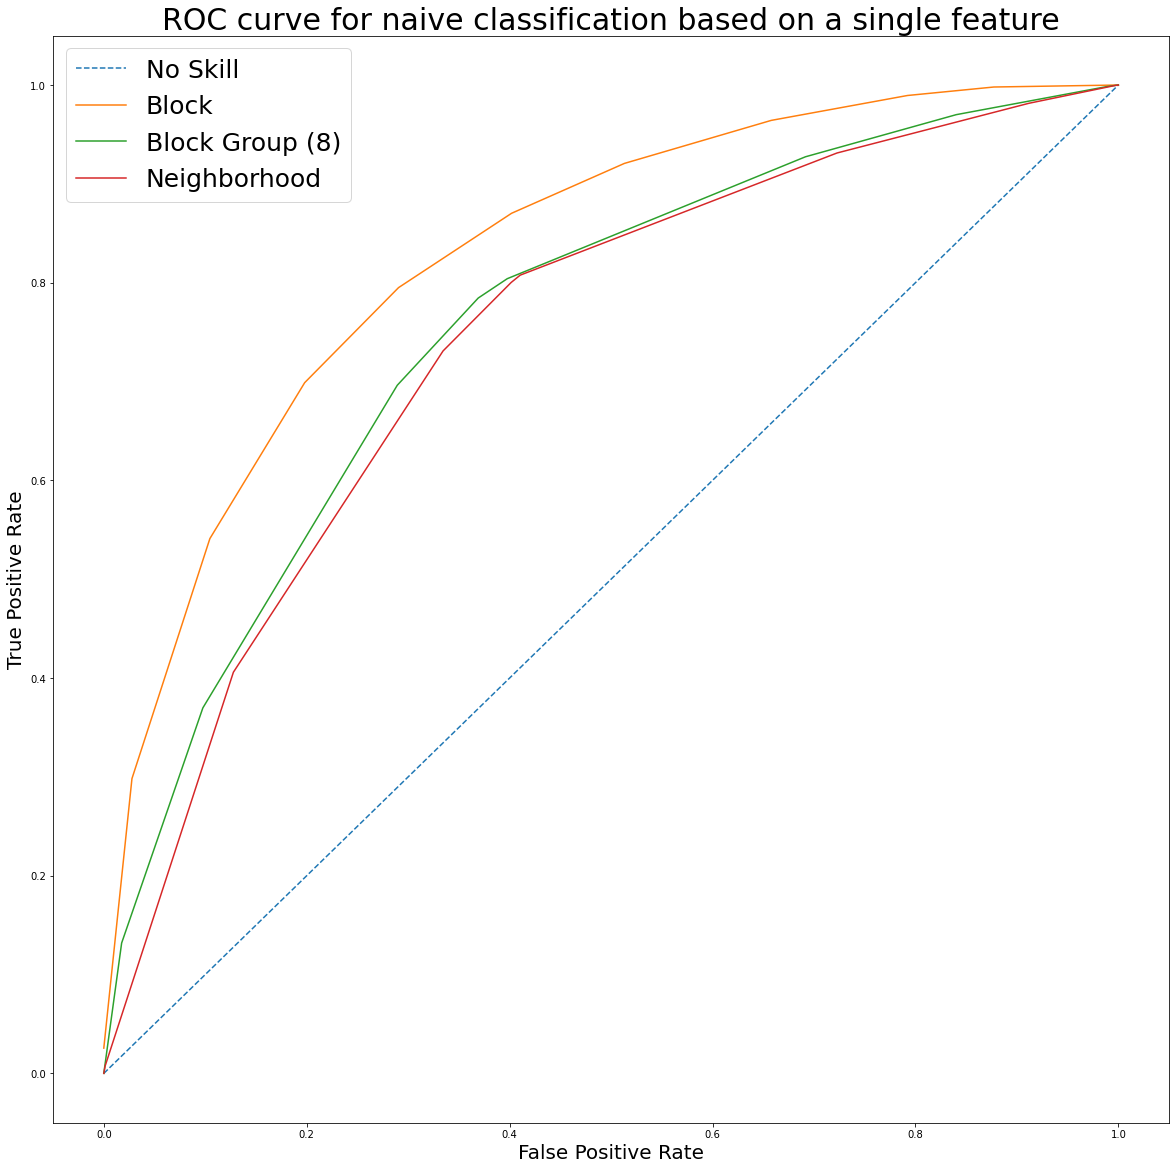

In [9]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
param_arr = [x/10 for x in range(11)]

for classifier, title in zip([c1, c2, c3], ["Block", "Block Group (8)", "Neighborhood"]):
    print(title)
    df = classifier.get_roc(param_arr)
    data_fpr = df["fpr"].values
    data_tpr = df["tpr"].values
    ax.plot(data_fpr, data_tpr, linestyle='solid', label=title)

ax.legend(loc="lower right")
plt.legend(fontsize=25)

ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_title("ROC curve for naive classification based on a single feature", fontsize=30)

plt.show()

For a few values of the threshold we can view the differences in the solution:

In [ ]:
fig, Axes = plt.subplots(figsize=(60,60), nrows=3, ncols=3)

fpr = []
fnr = []

for alpha, i in zip([0.25, 0.5, 0.75], [0, 1, 2]):
    j=0
    for classifier in [c1, c2, c3]:
        map_df = classifier.get_tiebreaker_map(alpha, "tiebreaker")
        Axes[i, j] = map_df.plot(column="tiebreaker", ax=Axes[i,j], cmap="viridis",
                                 legend=False, missing_kwds={'color': 'lightgrey'})
        plt.axis('off')
        j += 1
        fpr.append(classifier.fpr(alpha))
        fnr.append(classifier.fnr(alpha))

fpr = np.reshape(np.array(fpr), (3,3))
fnr = np.reshape(np.array(fnr), (3,3))
        
cols = ["Block Level Focal (%)", "Group Level Focal (%)", "Neighborhood Level Focal (%)"]
rows = ["> 25%", "> 50%", "> 75%"]
for ax, col in zip(Axes[0], cols):
    ax.set_title(col, fontsize=80)
for ax, row in zip(Axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=60)
fig.tight_layout()
plt.show()
plt.savefig("outputs/neighborhood.png")

We can analyze the false positive and false negative rate for each of those thresholds:

In [ ]:
fpr_df = pd.DataFrame(fpr, columns=["Block", "Block Group", "Neighborhood"], index=["Focal > 25%", "Focal > 50%", "Focal > 75%"])
fnr_df = pd.DataFrame(fnr, columns=["Block", "Block Group", "Neighborhood"], index=["Focal > 25%", "Focal > 50%", "Focal > 75%"])

In [ ]:
print("False Positive Rate")
print(fpr_df)
print("\n\nFalse Negative Rate")
print(fnr_df)

We would like to combine the neighborhood condition with conditions we already have. For example:

$$( (\text{pctALLPI }\geq 50\% \quad\text{AND}\quad\text{pctFRL }\geq 60\%)\quad\text{OR}\quad\text{pctFocal }\geq 70\%)\quad\text{AND}\quad\text{BG_pctFocal }\geq \gamma$$


So far the propositions take only one nested list, so we can rephrase the above into:

$$ (\text{pctAALPI }\geq 0.5\quad\text{OR}\quad\text{pctFocal} \geq 0.7)\quad \text{AND}\quad (\text{pctFRL } \geq 0.6 \quad\text{OR}\quad \text{pctFocal} \geq 0.7)\quad\text{AND}\quad \text{pctFocalNbhd} \geq \gamma $$

In [ ]:
pc_comb = pc.PropositionalClassifier([("pctAALPI", "pctFocal"), ("pctFRL", "pctFocal"), "BG_pctFocal"], ["or", "and", "or", "and"], group_criterion="nbhd")
pc_comb.statement

In [ ]:
gamma_list = [0, 0.25, 0.5, 0.75]
fig, Axes = plt.subplots(figsize=(40,40), nrows=2, ncols=2)
fpr, fnr = [], []

for gamma, ax in zip(gamma_list, Axes.flatten()):
    params = [0.5, 0.7, 0.6, 0.7, gamma]
    map_df = pc_comb.get_tiebreaker_map(params, "tiebreaker")
    ax = map_df.plot(column="tiebreaker", ax=ax, cmap="viridis",
                     legend=False, missing_kwds={'color': 'lightgrey'})
    ax.set_title("$\gamma = $"+str(100*gamma)+"%", fontsize=40)
    plt.axis('off')
    j += 1
    fpr.append(pc_comb.fpr(params))
    fnr.append(pc_comb.fnr(params))

fpr = 100*np.reshape(np.array(fpr), (2,2)).round(decimals=2)
fnr = 100*np.reshape(np.array(fnr), (2,2)).round(decimals=2)
        
fig.tight_layout()
plt.show()

In [ ]:
fpr_df = pd.DataFrame(fpr)
fnr_df = pd.DataFrame(fnr)
print("False Positive Rate (%)")
print(fpr_df)
print("\n\nFalse Negative Rate (%)")
print(fnr_df)

### 1.1. Choosing Nice Classifiers:

Using the above ideas, we can generate a set of viable classifiers to optimize parameters and then run through the choice simulator. Ideally (as of Jul 30), we would like the classifier to not reflect individual features such as race (AALPI) and income (FRL). The only features we will be considering in this section, then, are the number of Focal students as a whole, and the number of Combo Focal students (both in block and neighborhood level).

For example, let's plot realizations of the classifier:

$$ (\text{Focal } \geq \alpha \quad\text{or}\quad\text{Both } \geq \beta)\quad\text{and}\quad\text{NBHD Focal } \geq \gamma $$ 

Because both is a subset of the union, we have that the percentage of Focal students in a block is always greater than the percentage of combo students in that block. That is, we can restrain the choice of parameters above for those when $\alpha > \beta$.

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
param_arr = [x/10 for x in range(11)]

naive = NaiveClassifier(positive_group="nFocal", rate=True)
naive_roc = naive.get_roc()
ax.plot(naive_roc["fpr"].values, naive_roc["tpr"].values, linestyle='--', label='Naive')

#naive_both = NaiveClassifier(positive_group="nBoth", rate=True)
#naive_both_roc = naive_both.get_roc()
#ax.plot(naive_both_roc["fpr"].values, naive_both_roc["tpr"].values, linestyle='--', label='Naive (COMBO)')

classifier = pc.PropositionalClassifier([("pctFocal", "pctBoth"), "BG_pctFocal"], ["or", "and"], group_criterion="nbhd")

count=0
for alpha in [x/10 for x in range(11)]:
    for beta in [x/10 for x in range(int(10*alpha +1))]:
        for gamma in [x/10 for x in range(11)]:
            param_arr=[[alpha, beta, gamma]]
            df = classifier.get_roc(param_arr)            
            data_fpr = df["fpr"].values
            data_tpr = df["tpr"].values
            ax.scatter(data_fpr, data_tpr, label='_nolegend_')
            count += 1

print("Tried ", count, " realizations")
#ax.legend(loc="lower right")
#plt.legend(fontsize=25)

ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_title("Realizations of Classifier", fontsize=30)

plt.show()

We can also try to, for a pair of alphas and betas, plot a curve as we vary gamma:

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
param_arr = [x/10 for x in range(11)]

classifier = pc.PropositionalClassifier([("pctFocal", "pctBoth"), "BG_pctFocal"], ["or", "and"], group_criterion="nbhd")

naive = NaiveClassifier(positive_group="nFocal", rate=True)
naive_roc = naive.get_roc()
ax.plot(naive_roc["fpr"].values, naive_roc["tpr"].values, linestyle='--', label='Naive')

count=0
for alpha in [x/5 for x in range(6)]:
    for beta in [x/5 for x in range(int(5*alpha))]:
        x_arr, y_arr = [], []
        for gamma in [x/10 for x in range(11)]:
            param_arr=[[alpha, beta, gamma]]
            df = classifier.get_roc(param_arr)            
            x_arr.extend(df["fpr"].values)
            y_arr.extend(df["tpr"].values)
        curve = "alpha = " + str(alpha) + ", beta = " + str(beta)
        ax.plot(x_arr, y_arr, label=curve, linestyle='solid')

ax.legend(loc="lower right")
plt.legend(fontsize=25)

ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_title("Realizations of Classifier", fontsize=30)

plt.show()

Fixing values of alpha and beta, we can plot the values for certain gamma thresholds:

In [ ]:
gamma_list = [0, 0.25, 0.5, 0.75]
fig, Axes = plt.subplots(figsize=(40,40), nrows=2, ncols=2)
fpr, fnr = [], []

classifier = pc.PropositionalClassifier([("pctFocal", "pctBoth"), "BG_pctFocal"], ["or", "and"], group_criterion="nbhd")

for gamma, ax in zip(gamma_list, Axes.flatten()):
    params = [0.6, 0.4, gamma]
    map_df = classifier.get_tiebreaker_map(params, "tiebreaker")
    ax = map_df.plot(column="tiebreaker", ax=ax, cmap="viridis",
                     legend=False, missing_kwds={'color': 'lightgrey'})
    ax.set_title("$\gamma = $"+str(100*gamma)+"%", fontsize=40)
    plt.axis('off')
    j += 1
    fpr.append(classifier.fpr(params))
    fnr.append(classifier.fnr(params))

fpr = 100*np.reshape(np.array(fpr), (2,2)).round(decimals=2)
fnr = 100*np.reshape(np.array(fnr), (2,2)).round(decimals=2)
        
fig.tight_layout()
plt.show()

fpr_df = pd.DataFrame(fpr)
fnr_df = pd.DataFrame(fnr)
print("False Positive Rate (%)")
print(fpr_df)
print("\n\nFalse Negative Rate (%)")
print(fnr_df)

Note however that the FPR and FNR are not tailored to reflect the design changes in our tiebreaker! For example they penalize the exclusion of students in the Northwest, whereas we would like to do that.

## 2. Neighborhood Socioeconomic Score (Henry's index) based Proxies: